In [4]:
# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

SyntaxError: invalid syntax (<ipython-input-4-d3010dc2e625>, line 4)

In [7]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [9]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [10]:
def show(qmaze):
    try:
        plt.grid('on')  # Enable grid lines on the plot
        nrows, ncols = qmaze.maze.shape  # Get the number of rows and columns in the maze
        ax = plt.gca()  # Get the current axis of the plot
        ax.set_xticks(np.arange(0.5, nrows, 1))  # Set x-tick positions
        ax.set_yticks(np.arange(0.5, ncols, 1))  # Set y-tick positions
        ax.set_xticklabels([])  # Remove x-tick labels
        ax.set_yticklabels([])  # Remove y-tick labels

        canvas = np.copy(qmaze.maze)  # Create a copy of the maze to use for plotting
        for row, col in qmaze.visited:
            canvas[row, col] = 0.6  # Mark visited cells with a value of 0.6 (gray color)

        pirate_row, pirate_col, _ = qmaze.state  # Get the current position of the pirate (agent)
        canvas[pirate_row, pirate_col] = 0.3  # Mark the pirate cell with a value of 0.3 (darker gray)

        canvas[nrows-1, ncols-1] = 0.9  # Mark the treasure cell with a value of 0.9 (white)

        img = plt.imshow(canvas, interpolation='none', cmap='gray')  # Display the maze using a gray color map
        return img  # Return the image object

    except AttributeError as e:
        print(f"Attribute error: {e}. Make sure that qmaze has the required attributes 'maze', 'visited', and 'state'.")
    except TypeError as e:
        print(f"Type error: {e}. Ensure that the maze and its properties are properly defined and initialized.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}.")


The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [11]:
# Define constants for action directions
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration factor for epsilon-greedy strategy
epsilon = 0.1

# Dictionary to map actions to their corresponding directions
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

# Number of possible actions
num_actions = len(actions_dict)

try:
    # Verify that actions_dict contains all required actions
    for action in [LEFT, UP, RIGHT, DOWN]:
        if action not in actions_dict:
            raise ValueError(f"Action {action} is missing from actions_dict")

    # Check if epsilon is within a valid range
    if not (0 <= epsilon <= 1):
        raise ValueError("Exploration factor epsilon must be between 0 and 1")

    # Check if num_actions is correct
    if num_actions != 4:
        raise ValueError(f"Number of actions should be 4, but got {num_actions}")

except ValueError as e:
    print(f"Value error: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


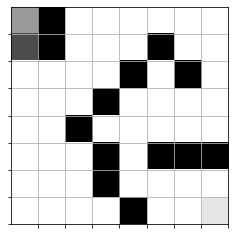

In [12]:
# Initialize the maze environment with the given maze configuration
qmaze = TreasureMaze(maze)

# Perform an action (move DOWN) in the maze environment
# This returns the updated canvas (maze state), reward, and game_over status
canvas, reward, game_over = qmaze.act(DOWN)

# Print the reward obtained from the action
print("reward=", reward)

# Display the current state of the maze environment
show(qmaze)


This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [13]:
def play_game(model, qmaze, pirate_cell):
    try:
        # Reset the maze environment with the pirate starting at the specified cell
        qmaze.reset(pirate_cell)
        
        # Observe the initial state of the environment
        envstate = qmaze.observe()
        
        while True:
            prev_envstate = envstate  # Store the previous state
            
            # Get the next action based on the current state
            q = model.predict(prev_envstate)
            action = np.argmax(q[0])  # Select the action with the highest Q-value
            
            # Apply the selected action, and get the new state, reward, and game status
            envstate, reward, game_status = qmaze.act(action)
            
            # Check if the game is won
            if game_status == 'win':
                return True
            
            # Check if the game is lost
            elif game_status == 'lose':
                return False

    except AttributeError as e:
        print(f"Attribute error: {e}. Ensure that qmaze and model have the required attributes and methods.")
    except TypeError as e:
        print(f"Type error: {e}. Ensure that the inputs are of the correct type and properly initialized.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [14]:
def completion_check(model, qmaze):
    try:
        # Iterate through each cell in the list of free cells in the maze
        for cell in qmaze.free_cells:
            # Check if there are valid actions available from the current cell
            if not qmaze.valid_actions(cell):
                return False  # Return False if no valid actions are available
            
            # Play the game starting from the current cell
            # If the game cannot be won from this cell, return False
            if not play_game(model, qmaze, cell):
                return False
        
        # If all cells pass the checks, return True indicating completion
        return True

    except AttributeError as e:
        print(f"Attribute error: {e}. Ensure that qmaze has the 'free_cells' and 'valid_actions' attributes/methods.")
    except TypeError as e:
        print(f"Type error: {e}. Check that the input types for 'model' and 'qmaze' are correct and properly initialized.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [15]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [16]:
def qtrain(model, maze, **opt):
    try:
        global epsilon 
        
        # Hyperparameters
        n_epoch = opt.get('n_epoch', 15000)  # Number of epochs (full passes through the training dataset)
        max_memory = opt.get('max_memory', 1000)  # Maximum size of the experience replay buffer
        data_size = opt.get('data_size', 50)  # Number of experiences used for each training step
        decay_rate = 0.1  # Rate at which exploration decays over time
        
        start_time = datetime.datetime.now()
        qmaze = TreasureMaze(maze)  # Initialize the maze environment
        experience = GameExperience(model, max_memory=max_memory)  # Initialize the experience replay buffer
        
        win_history = []  # List to keep track of wins over epochs
        hsize = qmaze.maze.size // 2  # Window size for calculating win rate (half the size of the maze)
        win_rate = 0.0  # Initial win rate
        
        for epoch in range(n_epoch):
            try:
                agent_cell = random.choice(qmaze.free_cells)  # Randomly select a starting position for the agent
                qmaze.reset(agent_cell)  # Reset the maze environment with the agent at the starting position
                envstate = qmaze.observe()  # Get the initial state of the environment
                
                n_episodes, loss = 0, 0.0  # Initialize episode counter and loss
                game_over = False
                
                while not game_over:
                    previous_envstate = envstate
                    valid_actions = qmaze.valid_actions()  # Retrieve a list of valid actions from the current state
                    
                    if not valid_actions:
                        break  # Exit the loop if there are no valid actions available
                    
                    # Decide between exploration (random action) and exploitation (best action)
                    if 1 / (1 + epoch * decay_rate) < epsilon:
                        action = np.argmax(experience.predict(previous_envstate))  # Choose action with highest Q-value (exploitation)
                    else:
                        action = random.choice(valid_actions)  # Choose a random action (exploration)
                    
                    envstate, reward, game_status = qmaze.act(action)  # Perform the chosen action and observe the new state and reward
                    experience.remember([previous_envstate, action, reward, envstate, game_status])  # Store the experience in memory
                    n_episodes += 1
                    
                    # Train the model using experiences from the replay buffer
                    inputs, targets = experience.get_data(data_size)  # Retrieve a batch of training data
                    model.fit(inputs, targets, epochs=4, batch_size=16, verbose=0)  # Train the model with the training data
                    loss = model.evaluate(inputs, targets, verbose=0)  # Evaluate the model on the training data
                    
                    if game_status == 'win':
                        win_history.append(1)  # Append a win (1) to the win history
                        game_over = True  # End the episode
                    elif game_status == 'lose':
                        win_history.append(0)  # Append a loss (0) to the win history
                        game_over = True  # End the episode
                    
                    # Calculate the win rate over the history window
                    win_rate = sum(win_history[-hsize:]) / hsize if len(win_history) > 0 else 0
                
                # Print training progress
                elapsed_time = format_time((datetime.datetime.now() - start_time).total_seconds())
                print(f"Epoch: {epoch:03d}/{n_epoch-1} | Loss: {loss:.4f} | Episodes: {n_episodes} | "
                      f"Win count: {sum(win_history)} | Win rate: {win_rate:.3f} | Time: {elapsed_time}")
                
                # Adjust the exploration rate and check if the training is complete
                if win_rate > 0.9:
                    epsilon = 0.05  # Reduce exploration rate to focus more on exploitation
                if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
                    print(f"Reached 100% win rate at epoch: {epoch}")
                    break  # Exit training if a high win rate is consistently achieved
            except Exception as e:
                print(f"Error during epoch {epoch}: {e}")
        
        print(f"Training completed in {format_time((datetime.datetime.now() - start_time).total_seconds())}")
        return elapsed_time
    except Exception as e:
        print(f"Error in qtrain: {e}")

def format_time(seconds):
    # Format the elapsed time based on its length
    if seconds < 400:
        return f"{seconds:.1f} seconds"  # Format time in seconds for short durations
    elif seconds < 4000:
        return f"{seconds / 60.0:.2f} minutes"  # Format time in minutes for moderate durations
    else:
        return f"{seconds / 3600.0:.2f} hours"  # Format time in hours for long durations

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

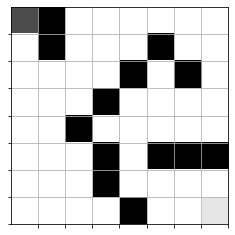

In [17]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [18]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0012 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | Time: 26.1 seconds
Epoch: 001/14999 | Loss: 0.0014 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | Time: 46.1 seconds
Epoch: 002/14999 | Loss: 0.0012 | Episodes: 148 | Win count: 1 | Win rate: 0.031 | Time: 75.5 seconds
Epoch: 003/14999 | Loss: 0.0013 | Episodes: 145 | Win count: 1 | Win rate: 0.031 | Time: 105.2 seconds
Epoch: 004/14999 | Loss: 0.0012 | Episodes: 150 | Win count: 1 | Win rate: 0.031 | Time: 134.4 seconds
Epoch: 005/14999 | Loss: 0.0014 | Episodes: 149 | Win count: 1 | Win rate: 0.031 | Time: 165.3 seconds
Epoch: 006/14999 | Loss: 0.0009 | Episodes: 73 | Win count: 2 | Win rate: 0.062 | Time: 180.8 seconds
Epoch: 007/14999 | Loss: 0.0016 | Episodes: 153 | Win count: 2 | Win rate: 0.062 | Time: 210.9 seconds
Epoch: 008/14999 | Loss: 0.0011 | Episodes: 63 | Win count: 3 | Win rate: 0.094 | Time: 222.0 seconds
Epoch: 009/14999 | Loss: 0.0017 | Episodes: 139 | Win count: 3 | Win rate: 0.0

Epoch: 080/14999 | Loss: 0.0012 | Episodes: 141 | Win count: 25 | Win rate: 0.219 | Time: 32.50 minutes
Epoch: 081/14999 | Loss: 0.0012 | Episodes: 147 | Win count: 25 | Win rate: 0.219 | Time: 32.96 minutes
Epoch: 082/14999 | Loss: 0.0005 | Episodes: 144 | Win count: 25 | Win rate: 0.219 | Time: 33.37 minutes
Epoch: 083/14999 | Loss: 0.0009 | Episodes: 143 | Win count: 25 | Win rate: 0.219 | Time: 33.78 minutes
Epoch: 084/14999 | Loss: 0.0008 | Episodes: 8 | Win count: 26 | Win rate: 0.250 | Time: 33.80 minutes
Epoch: 085/14999 | Loss: 0.0009 | Episodes: 31 | Win count: 27 | Win rate: 0.281 | Time: 33.89 minutes
Epoch: 086/14999 | Loss: 0.0015 | Episodes: 153 | Win count: 27 | Win rate: 0.281 | Time: 34.33 minutes
Epoch: 087/14999 | Loss: 0.0013 | Episodes: 146 | Win count: 27 | Win rate: 0.281 | Time: 34.78 minutes
Epoch: 088/14999 | Loss: 0.0016 | Episodes: 41 | Win count: 28 | Win rate: 0.281 | Time: 34.90 minutes
Epoch: 089/14999 | Loss: 0.0012 | Episodes: 4 | Win count: 29 | Win 

Epoch: 160/14999 | Loss: 0.0004 | Episodes: 137 | Win count: 57 | Win rate: 0.500 | Time: 54.94 minutes
Epoch: 161/14999 | Loss: 0.0004 | Episodes: 137 | Win count: 57 | Win rate: 0.469 | Time: 55.26 minutes
Epoch: 162/14999 | Loss: 0.0002 | Episodes: 9 | Win count: 58 | Win rate: 0.469 | Time: 55.28 minutes
Epoch: 163/14999 | Loss: 0.0006 | Episodes: 140 | Win count: 58 | Win rate: 0.438 | Time: 55.57 minutes
Epoch: 164/14999 | Loss: 0.0001 | Episodes: 1 | Win count: 59 | Win rate: 0.438 | Time: 55.58 minutes
Epoch: 165/14999 | Loss: 0.0001 | Episodes: 138 | Win count: 59 | Win rate: 0.438 | Time: 55.86 minutes
Epoch: 166/14999 | Loss: 0.0001 | Episodes: 144 | Win count: 59 | Win rate: 0.438 | Time: 56.15 minutes
Epoch: 167/14999 | Loss: 0.0002 | Episodes: 6 | Win count: 60 | Win rate: 0.469 | Time: 56.16 minutes
Epoch: 168/14999 | Loss: 0.0001 | Episodes: 135 | Win count: 60 | Win rate: 0.469 | Time: 56.41 minutes
Epoch: 169/14999 | Loss: 0.0005 | Episodes: 5 | Win count: 61 | Win ra

'62.78 minutes'

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

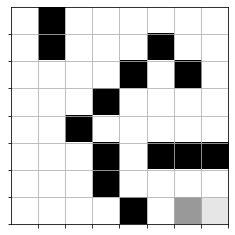

In [19]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

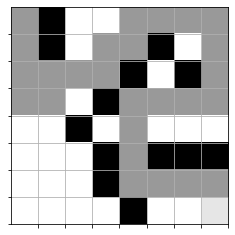

In [20]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.